## Data Cleaning

In [78]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
from string import ascii_letters

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import utils


application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

# select only the rows where ZERO BALANCE REMOVAL UPB is not null
data_full = data_full[data_full['ZERO BALANCE REMOVAL UPB'].notnull()]

data_full['LGD'] = data_full['ACTUAL LOSS CALCULATION']/data_full['ZERO BALANCE REMOVAL UPB'] 

########### data cleaning ###########
data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True)

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)


# List of columns to convert to datetime
date_columns = [
    'MONTHLY REPORTING PERIOD', 
    'FIRST PAYMENT DATE', 
    'MATURITY DATE'
]

# Convert the specified columns to datetime
for column in date_columns:
    if column in data_full.columns:
        data_full[column] = pd.to_datetime(data_full[column], errors='coerce')

# drop the rows where the ACTUAL LOSS CALCULATION is null
data_full = data_full[data_full['ACTUAL LOSS CALCULATION'].notnull()]

# change the object type columns to category
cat_columns = data_full.select_dtypes(include=['object']).columns
for column in cat_columns:
    data_full[column] = data_full[column].astype('category')
    data_full[column] = data_full[column].astype('category')


# make training data
data_full_in_time = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']

# remove columns that arent needed
data_full_in_time.drop(columns=['MONTHLY REPORTING PERIOD', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                        'DUE DATE OF LAST PAID INSTALLMENT (DDLPI)', 'MI RECOVERIES',
                        'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES',
                        'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS',
                        'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES','ACTUAL LOSS CALCULATION'], inplace=True)

# remove columns that arent needed
data_full_oot.drop(columns=['MONTHLY REPORTING PERIOD', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                        'DUE DATE OF LAST PAID INSTALLMENT (DDLPI)', 'MI RECOVERIES',
                        'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES',
                        'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS',
                        'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES','ACTUAL LOSS CALCULATION'], inplace=True)

# Split the data into features and target
X = data_full_in_time.drop(columns=['LGD'])
y = data_full_in_time['LGD']

# split the data into features and target for oot
X_oot = data_full_oot.drop(columns=['LGD'])
y_oot = data_full_oot['LGD']

# do split test train but do it by the LOAN SEQUENCE NUMBER
X_train, X_test, y_train, y_test = utils.train_test_split_by_group(X, y, 'LOAN SEQUENCE NUMBER', test_size=0.2,  random_state=42)

# remove the LOAN SEQUENCE NUMBER from the train and test data
X_train.drop(columns=['LOAN SEQUENCE NUMBER'], inplace=True)
X_test.drop(columns=['LOAN SEQUENCE NUMBER'], inplace=True)

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [84]:
X_train


,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,DEFECT SETTLEMENT DATE,ZERO BALANCE CODE,ZERO BALANCE EFFECTIVE DATE,CURRENT INTEREST RATE,CURRENT NON-INTEREST BEARING UPB,CUMULATIVE MODIFICATION COST,...,PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER_F09Q20296500,PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER_F09Q20707261,PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER_F99Q20261819,PROGRAM INDICATOR_F,PROGRAM INDICATOR_H,PROGRAM INDICATOR_R,RELIEF REFINANCE INDICATOR_Y,MI CANCELLATION INDICATOR_9,MI CANCELLATION INDICATOR_N,MI CANCELLATION INDICATOR_Y
496,0.0,3,94,266,NaN,9.0,202112.0,4.500,0.0,0.00,...,0,0,0,0,0,0,1,1,0,0
512,0.0,3,94,266,NaN,9.0,202112.0,4.750,0.0,0.00,...,0,0,0,0,0,0,1,1,0,0
1425,0.0,36,93,267,NaN,2.0,202111.0,4.625,0.0,0.00,...,0,0,0,0,0,0,0,1,0,0
1685,0.0,3,87,273,NaN,9.0,202105.0,5.500,0.0,0.00,...,0,0,0,0,0,0,1,1,0,0
1767,0.0,41,42,438,NaN,2.0,202204.0,4.250,0.0,13744.92,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471855,0.0,29,31,329,NaN,2.0,202205.0,3.875,0.0,0.00,...,0,0,0,0,0,0,0,0,1,0
478938,0.0,0,26,334,NaN,2.0,202201.0,4.125,0.0,0.00,...,0,0,0,0,0,0,0,0,0,0
492779,0.0,0,28,332,202303.0,3.0,202204.0,4.375,0.0,0.00,...,0,0,0,0,0,0,0,0,1,0
526906,0.0,0,20,340,NaN,2.0,202110.0,5.625,0.0,0.00,...,0,0,0,0,0,0,0,0,1,0


In [81]:
from sklearn.preprocessing import StandardScaler

# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Scale numeric columns only
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [82]:
# get the top correlations with the target
correlations = data_full_in_time.corr()['LGD'].sort_values(ascending=False)

correlations

LGD                                       1.000000
ZERO BALANCE REMOVAL UPB                  0.311717
ORIGINAL UPB                              0.311489
MORTGAGE INSURANCE PERCENTAGE (MI %)      0.292279
CREDIT SCORE                              0.174331
REMAINING MONTHS TO LEGAL MATURITY        0.163103
DELINQUENT ACCRUED INTEREST               0.159538
CURRENT LOAN DELINQUENCY STATUS           0.135499
ORIGINAL LOAN TERM                        0.116973
ESTIMATED LOAN TO VALUE (ELTV)            0.091249
NUMBER OF BORROWERS                       0.062104
ZERO BALANCE EFFECTIVE DATE               0.059701
POSTAL CODE                               0.036782
CURRENT MONTH MODIFICATION COST           0.028085
CUMULATIVE MODIFICATION COST              0.026360
CURRENT INTEREST RATE                     0.018579
ORIGINAL INTEREST RATE                    0.009041
PROPERTY VALUATION METHOD                -0.139768
DEFAULT                                  -0.143766
ORIGINAL COMBINED LOAN-TO-VALUE

## XGBoosting

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)

param_grid = {
    'n_estimators': [150, 180, 200],      
    'max_depth': [3, 4, 5],               
    'learning_rate': [0.03, 0.05, 0.07],  
    'subsample': [0.7, 0.8, 0.9],          
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=0
)

grid_search_xgb.fit(X_train_scaled, y_train)

best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost parameters:", grid_search_xgb.best_params_)

y_pred_xgb_train = best_xgb.predict(X_train_scaled)
y_pred_xgb_test = best_xgb.predict(X_test_scaled)

print("\n XGB Train Performance:")
print(f"R²: {r2_score(y_train, y_pred_xgb_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_xgb_train):}")

print("\n XGB Test Performance:")
print(f"R²: {r2_score(y_test, y_pred_xgb_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb_test):}")




Best XGBoost parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.9}

 XGB Train Performance:
R²: 0.8802
MSE: 0.010685302048170144

 XGB Test Performance:
R²: 0.4614
MSE: 0.034059430644950574


<Figure size 720x576 with 0 Axes>

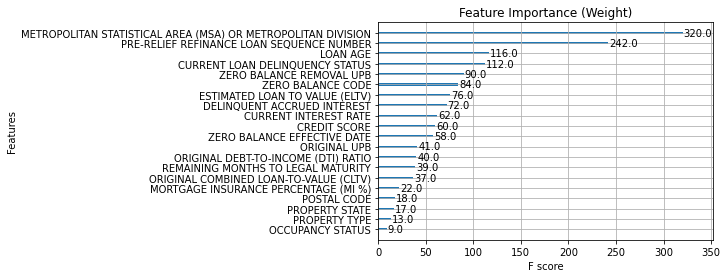

In [60]:
# get the xgboost feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, max_num_features=20, importance_type='weight', title='Feature Importance (Weight)', xlabel='F score')
plt.show()


In [ ]:
import shap

X_oot = data_full_oot.drop(columns=['LGD'])
y_oot = data_full_oot['LGD']

# Create SHAP explainer from fitted model
explainer = shap.Explainer(best_xgb, X_oot)

# Compute SHAP values
shap_values = explainer(X_oot)

# Summary plot (variable importance overall)
shap.summary_plot(shap_values, X_oot)

# Automatically get top 5 important variables
top5_features = shap_values.abs.mean(0).values.argsort()[-5:][::-1]
top5_names = X_oot.columns[top5_features]

# Draw SHAP dependence plots
for feature in top5_names:
    shap.dependence_plot(feature, shap_values.values, X_oot, show=True)